# CAT Vs DOGS

In [45]:
# import
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D


from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = "#2c2c2cff"
plt.rcParams['figure.facecolor'] = "#2c2c2cff"

### --- Dataset ---

In [46]:
# Paramètres
BATCH_SIZE = 16
IMG_SIZE = (224, 224) # Redimensionnement automatique 

# Création du dataset d'entraînement
train_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/train',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='binary' # Ou 'categorical' si + de 2 classes
)

# Création du dataset de validation/test
val_ds = tf.keras.utils.image_dataset_from_directory(
    'dataset/test',
    shuffle=False, # Pas besoin de mélanger le test
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='binary'
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [47]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


1. Навигация по данным

- for batch in train_ds: — итерировать по батчам (images, labels).
    - train_ds.take(n) — взять первые n батчей.
    - train_ds.skip(n) — пропустить первые n батчей.

2. Преобразования данных

- map(func) — применяет функцию ко всем элементам датасета.
- filter(func) — оставляет только элементы, где func(element) возвращает True

3. Управление батчами и размером данных

- batch(batch_size) — задать размер батча (если не указан при создании)
- unbatch() — развернуть батчи обратно в отдельные элементы
- shuffle(buffer_size) — перемешать данные

In [48]:
for images, labels in train_ds.take(1):
    print(images.shape)  # (32, 32, 32, 3) если batch_size=32, image_size=(32,32)
    print(labels.shape)  # (32,)

(16, 224, 224, 3)
(16, 1)


### --- Visualisation ---

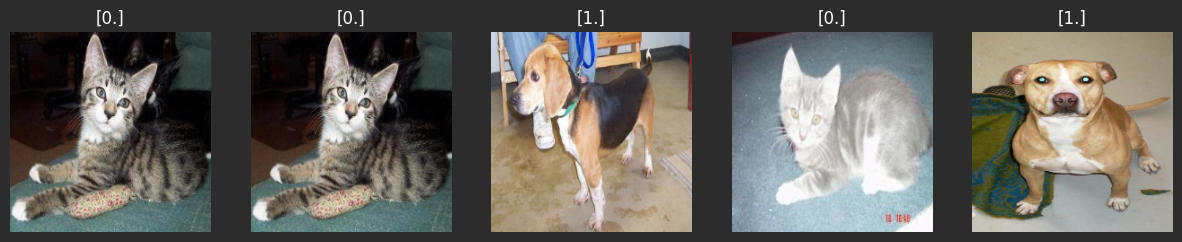

In [49]:
def show_batch_img(ds, n=5):

    for images, labels in ds.take(1):
        fig, axes = plt.subplots(1, n, figsize=(15, 5))
        for i in range(n):
            idx = np.random.randint(images.shape[0])  # случайный индекс внутри батча
            axes[i].imshow(images[idx].numpy().astype("uint8"))  # если изображения 0-255
            axes[i].set_title(str(labels[idx].numpy()))
            axes[i].axis("off")
        plt.show()
        break

show_batch_img(train_ds, 5)

### --- CNN ---

In [50]:
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),        # случайный горизонтальный переворот
    layers.RandomRotation(0.15),             # случайный поворот ±10%
    layers.RandomZoom(0.15),                 # случайное масштабирование ±10%
    layers.RandomTranslation(0.15, 0.15),     # случайный сдвиг по X и Y ±10%
    layers.RandomContrast(0.15),             # случайное изменение контраста ±10%
])

### --- model simple ---

In [51]:
model_1 = Sequential([
    Input((224, 224, 3)),
    data_augmentation,
    Conv2D(64, 3, activation="relu"),
    MaxPool2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(128, activation="relu"),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_1.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_loss",
        save_best_only=True
    ), 
    tf.keras.callbacks.TensorBoard(
        log_dir="logs/cnn_experiment/model_1",
        histogram_freq=0,   # гистограммы весов отключены, чтобы не падало
        write_graph=True,   # отображение графа модели
        update_freq='epoch',# обновлять логи после каждой эпохи
        profile_batch=0     # отключаем профилирование, оно грузит память
    )
]


history_1 = model_1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)

results_1 = model_1.evaluate(val_ds)
for name, value in zip(model_1.metrics_names, results_1):
    print(f"{name.capitalize():<12}: {value:.4f}")

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 99s 785ms/step - accuracy: 0.5220 - loss: 4.7913 - val_accuracy: 0.5420 - val_loss: 0.6813 - learning_rate: 0.0010
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 96s 772ms/step - accuracy: 0.5860 - loss: 0.6673 - val_accuracy: 0.5930 - val_loss: 0.6571 - learning_rate: 0.0010
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 94s 750ms/step - accuracy: 0.6225 - loss: 0.6591 - val_accuracy: 0.5970 - val_loss: 0.6549 - learning_rate: 0.0010
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 94s 749ms/step - accuracy: 0.6330 - loss: 0.6510 - val_accuracy: 0.6260 - val_loss: 0.6449 - learning_rate: 0.0010
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 93s 748ms/step - accuracy: 0.6530 - loss: 0.6373 - val_accuracy: 0.6470 - val_loss: 0.6287 - learning_rate: 0.0010
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 716ms/step - accuracy: 0.6500 - loss: 0.6269 - val_accuracy: 0.6440 - val_loss: 0.6426 - learning_rate: 0.0010
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 90s 719ms/step - accuracy: 0.6

<Figure size 640x480 with 0 Axes>

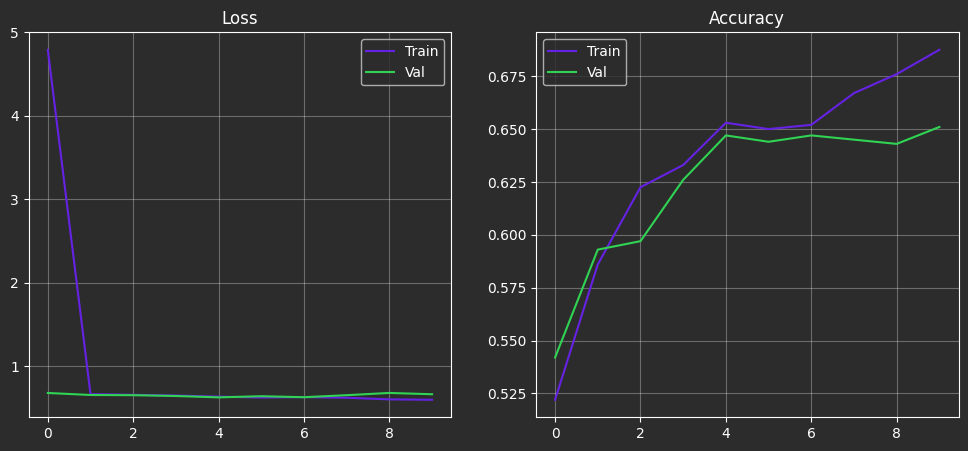

In [52]:
def show_results(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Loss
    axes[0].plot(history.history['loss'], color="#6622e4", label='Train')
    axes[0].plot(history.history['val_loss'], color="#30d353", label='Val')
    axes[0].set_title('Loss')
    axes[0].grid(alpha=0.3)
    axes[0].legend()

    # Accuracy
    axes[1].plot(history.history['accuracy'], color="#6622e4", label='Train')
    axes[1].plot(history.history['val_accuracy'],color="#30d353", label='Val')
    axes[1].set_title('Accuracy')
    axes[1].grid(alpha=0.3)
    axes[1].legend()

plt.tight_layout()
plt.show()

show_results(history_1)

In [53]:
model_2 = Sequential([
    Input((224, 224, 3)),
    data_augmentation,

    Conv2D(32, 3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Dropout(0.2),
        
    Conv2D(64, 3, activation="relu", padding='same'),
    MaxPool2D((2, 2)),
    Dropout(0.2),

    Flatten(),
    
    Dense(128, activation="relu"),
    Dropout(0.2),

    Dense(64, activation="relu"),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_loss",
        save_best_only=True
    ), 
    tf.keras.callbacks.TensorBoard(
        log_dir="logs/cnn_experiment/model_2",
        histogram_freq=0,   # гистограммы весов отключены, чтобы не падало
        write_graph=True,   # отображение графа модели
        update_freq='epoch',# обновлять логи после каждой эпохи
        profile_batch=0     # отключаем профилирование, оно грузит память
    )
]

model_2.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=['accuracy']
)

history_2 = model_2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

results_2 = model_2.evaluate(val_ds)
for name, value in zip(model_2.metrics_names, results_2):
    print(f"{name.capitalize():<12}: {value:.4f}")

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 59s 452ms/step - accuracy: 0.5185 - loss: 1.3339 - val_accuracy: 0.5000 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 449ms/step - accuracy: 0.5720 - loss: 0.6713 - val_accuracy: 0.5290 - val_loss: 0.6896 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 450ms/step - accuracy: 0.5980 - loss: 0.6724 - val_accuracy: 0.5320 - val_loss: 0.6873 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 448ms/step - accuracy: 0.6250 - loss: 0.6426 - val_accuracy: 0.6000 - val_loss: 0.6615 - learning_rate: 0.0010
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 444ms/step - accuracy: 0.6345 - loss: 0.6286 - val_accuracy: 0.5980 - val_loss: 0.6482 - learning_rate: 0.0010
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 55s 437ms/step - accuracy: 0.6515 - loss: 0.6297 - val_accuracy: 0.6440 - val_loss: 0.6348 - learning_rate: 0.0010
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 56s 445ms/step - accuracy: 0.6

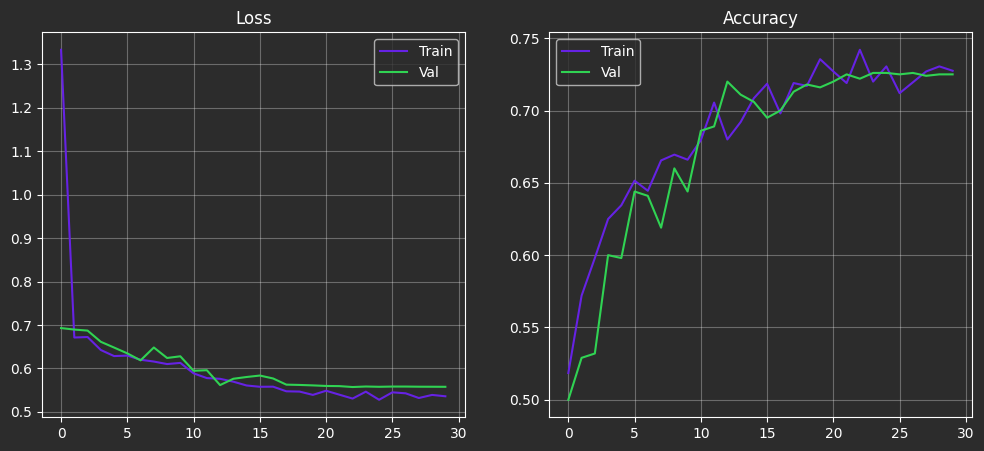

In [59]:
show_results(history_2)

### --- Additional training ---

In [55]:
# model_comp = tf.keras.models.load_model("best_model.keras")

# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# model_comp.compile(
#     optimizer=optimizer,
#     loss="binary_crossentropy",
#     metrics=["accuracy"]
# )

# history_finetune = model_comp.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=20,
#     callbacks=callbacks
# )


In [56]:
# def merge_histories(h1, h2):
#     merged = {}
#     for k in h1.history.keys():
#         merged[k] = h1.history[k] + h2.history.get(k, [])
#     return merged

# history_merged = merge_histories(history_comp, history_finetune)

# show_results(history_2)


In [57]:
# best_model = tf.keras.models.load_model("best_model.keras")

# results_comp = best_model.evaluate(val_ds)

# for name, value in zip(best_model.metrics_names, results_comp):
#     print(f"{name.capitalize():<12}: {value:.4f}")

# --- best model ---

In [60]:
model_3 = Sequential([
    Input((224, 224, 3)),
    data_augmentation,

    Conv2D(16, 3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Dropout(0.3),
        
    Conv2D(32, 3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, 3, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D((2,2)),
    Dropout(0.3),

    GlobalAveragePooling2D(),
    
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation="relu"),
    Dropout(0.3),

    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.75,
        patience=2,
        min_lr=1e-5
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_loss",
        save_best_only=True
    ), 
    tf.keras.callbacks.TensorBoard(
        log_dir="logs/cnn_experiment/model_3",
        histogram_freq=0,   # гистограммы весов отключены, чтобы не падало
        write_graph=True,   # отображение графа модели
        update_freq='epoch',# обновлять логи после каждой эпохи
        profile_batch=0     # отключаем профилирование, оно грузит память
    )
]

model_3.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=['accuracy']
)

history_3 = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

results_3 = model_3.evaluate(val_ds)
for name, value in zip(model_3.metrics_names, results_3):
    print(f"{name.capitalize():<12}: {value:.4f}")

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 33s 230ms/step - accuracy: 0.5065 - loss: 0.9289 - val_accuracy: 0.5000 - val_loss: 0.7431 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 222ms/step - accuracy: 0.5300 - loss: 0.8056 - val_accuracy: 0.5000 - val_loss: 0.7810 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 27s 217ms/step - accuracy: 0.5665 - loss: 0.7388 - val_accuracy: 0.5000 - val_loss: 0.7719 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 226ms/step - accuracy: 0.5635 - loss: 0.7257 - val_accuracy: 0.5400 - val_loss: 0.7026 - learning_rate: 7.5000e-04
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 225ms/step - accuracy: 0.5565 - loss: 0.7095 - val_accuracy: 0.5950 - val_loss: 0.6621 - learning_rate: 7.5000e-04
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 29s 229ms/step - accuracy: 0.5665 - loss: 0.7039 - val_accuracy: 0.6270 - val_loss: 0.6292 - learning_rate: 7.5000e-04
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 28s 221ms/step - a

In [65]:
model_3 = tf.keras.models.load_model("best_model.keras")

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.75,
        patience=2,
        min_lr=1e-5
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_loss",
        save_best_only=True
    ), 
    tf.keras.callbacks.TensorBoard(
        log_dir="logs/cnn_experiment/model_3+",
        histogram_freq=0,   # гистограммы весов отключены, чтобы не падало
        write_graph=True,   # отображение графа модели
        update_freq='epoch',# обновлять логи после каждой эпохи
        profile_batch=0     # отключаем профилирование, оно грузит память
    )
]

model_3.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


history_finetune = model_3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 496ms/step - accuracy: 0.5445 - loss: 0.6780 - val_accuracy: 0.5000 - val_loss: 0.7067 - learning_rate: 1.0000e-04
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 498ms/step - accuracy: 0.5685 - loss: 0.6728 - val_accuracy: 0.5310 - val_loss: 0.6917 - learning_rate: 1.0000e-04
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 62s 492ms/step - accuracy: 0.5660 - loss: 0.6726 - val_accuracy: 0.5850 - val_loss: 0.6668 - learning_rate: 1.0000e-04
Epoch 4/30
 13/125 ━━━━━━━━━━━━━━━━━━━━ 50s 455ms/step - accuracy: 0.5376 - loss: 0.6400

KeyboardInterrupt: 

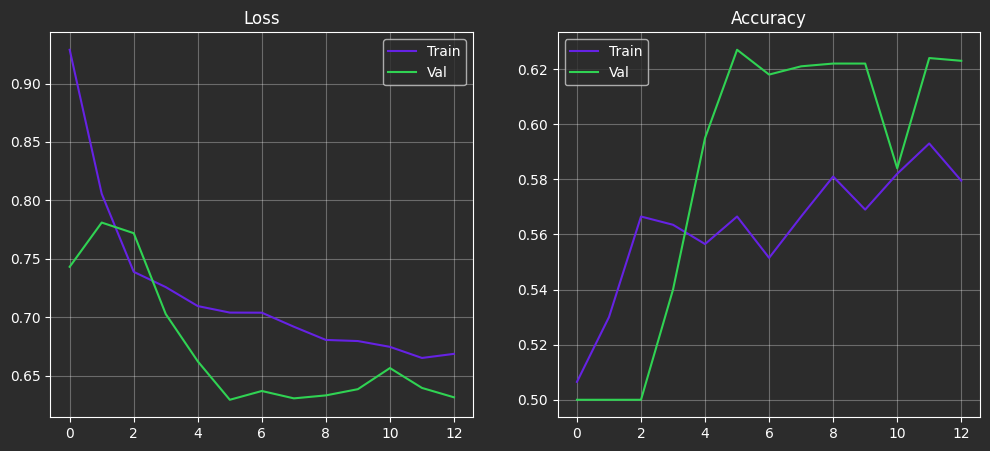

In [61]:
show_results(history_3)

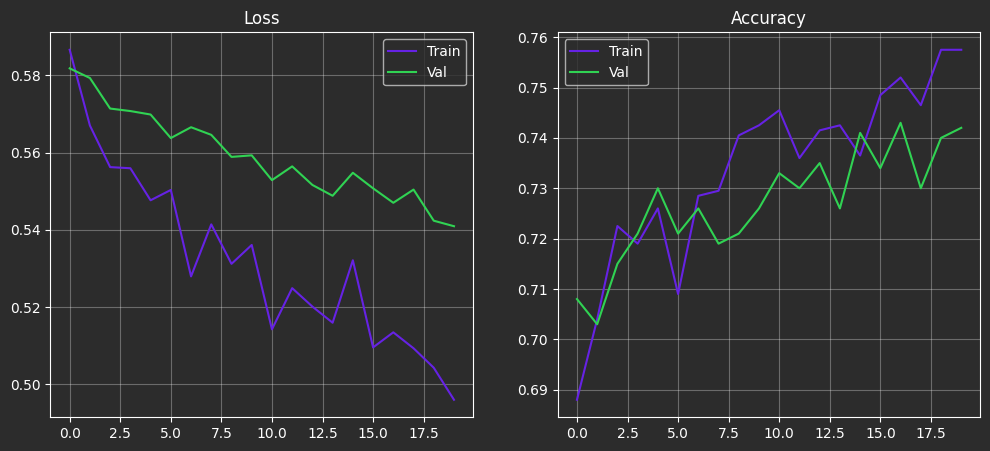

In [66]:
show_results(history_finetune)

### --- 4 ---

In [67]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, GlobalAveragePooling2D, Dense, Add

# Вход ----------------------------------------------------------------------
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

# Первый блок Conv
x1 = Conv2D(32, 3, padding='same')(x)
x1 = BatchNormalization()(x1)
x1 = Activation('relu')(x1)
x1 = MaxPool2D((2,2))(x1)
x1 = Dropout(0.3)(x1)

# Второй блок Conv
x2 = Conv2D(64, 3, padding='same')(x1)
x2 = BatchNormalization()(x2)
x2 = Activation('relu')(x2)
x2 = MaxPool2D((2,2))(x2)
x2 = Dropout(0.3)(x2)

# Второй блок Conv
x3 = Conv2D(128, 3, padding='same')(x2)
x3 = BatchNormalization()(x3)
x3 = Activation('relu')(x3)
x3 = MaxPool2D((2,2))(x3)
x3 = Dropout(0.3)(x3)

# Skip connection: добавляем вход первого блока к выходу второго
# Если размеры не совпадают, можно использовать Conv2D 1x1
x_skip = Conv2D(128, 1, strides=4, padding='same')(x1)  # strides=4, т.к. после MaxPool три раза spatial уменьшилось
x = Add()([x3, x_skip])
x = Activation('relu')(x)

# GlobalAveragePooling и Dense
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Создаём модель
model_4 = Model(inputs, outputs)

# Компиляция и обучение так же, как у вас
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.75,
        patience=2,
        min_lr=5e-5
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_loss",
        save_best_only=True
    ), 
    tf.keras.callbacks.TensorBoard(
        log_dir=f"logs/cnn_experiment/model_4",
        histogram_freq=0,   # гистограммы весов отключены, чтобы не падало
        write_graph=True,   # отображение графа модели
        update_freq='epoch',# обновлять логи после каждой эпохи
        profile_batch=0     # отключаем профилирование, оно грузит память
    )
]


model_4.compile(optimizer=optimizer,
                loss="binary_crossentropy",
                metrics=['accuracy'])

history_4= model_4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

results_4 = model_4.evaluate(val_ds)
for name, value in zip(model_4.metrics_names, results_4):
    print(f"{name.capitalize():<12}: {value:.4f}")


Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 490ms/step - accuracy: 0.5360 - loss: 0.7053 - val_accuracy: 0.5000 - val_loss: 0.6982 - learning_rate: 0.0010
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 488ms/step - accuracy: 0.5695 - loss: 0.6787 - val_accuracy: 0.5000 - val_loss: 0.6951 - learning_rate: 0.0010
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 486ms/step - accuracy: 0.5820 - loss: 0.6763 - val_accuracy: 0.5220 - val_loss: 0.6923 - learning_rate: 0.0010
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 491ms/step - accuracy: 0.5700 - loss: 0.6716 - val_accuracy: 0.5230 - val_loss: 0.6874 - learning_rate: 0.0010
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 486ms/step - accuracy: 0.5810 - loss: 0.6679 - val_accuracy: 0.5970 - val_loss: 0.6523 - learning_rate: 0.0010
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 487ms/step - accuracy: 0.5885 - loss: 0.6643 - val_accuracy: 0.6250 - val_loss: 0.6375 - learning_rate: 0.0010
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 63s 503ms/step - accuracy: 0.5

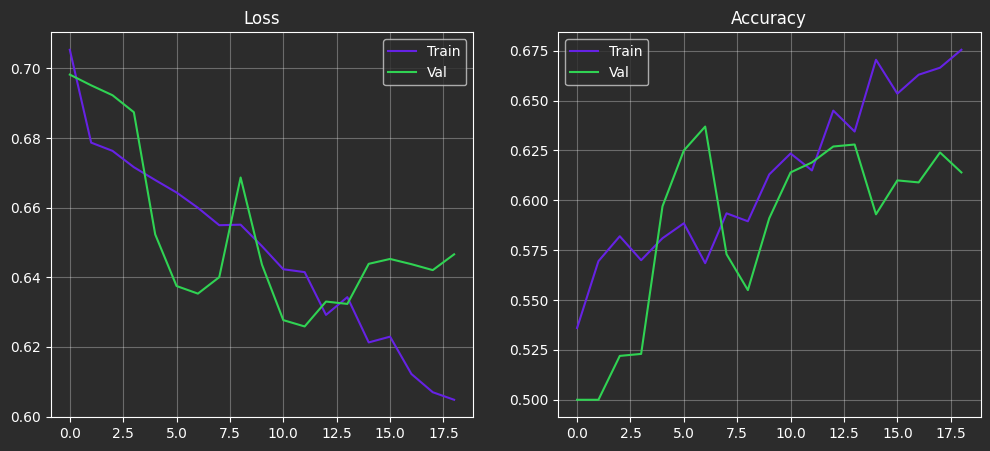

In [68]:
show_results(history_4)

In [69]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# --- Предобученная VGG16 ---
base_model = VGG16(
    weights='imagenet',      # Загружаем предобученные веса
    include_top=False,       # Убираем Dense слои
    input_shape=(224, 224, 3)
)

# Замораживаем веса базовой модели (чтобы не обучать сначала)
base_model.trainable = False

# Вход с аугментацией (если нужно)
inputs = Input(shape=(224, 224, 3))
x = inputs

# Добавляем GlobalAveragePooling + Dense
x = base_model(x, training=False)       # Используем базовую модель
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)  # бинарная классификация

# Создаем модель
model_VGG = Model(inputs, outputs)

# Компиляция
optimizer = Adam(learning_rate=1e-4)
model_VGG.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.75,
        patience=2,
        min_lr=5e-5
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_loss",
        save_best_only=True
    ), 
    tf.keras.callbacks.TensorBoard(
        log_dir=f"logs/cnn_experiment/model_VGG",
        histogram_freq=0,   # гистограммы весов отключены, чтобы не падало
        write_graph=True,   # отображение графа модели
        update_freq='epoch',# обновлять логи после каждой эпохи
        profile_batch=0     # отключаем профилирование, оно грузит память
    )
]
# Теперь можно обучать:
history = model_VGG.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 162s 1s/step - accuracy: 0.7020 - loss: 1.2797 - val_accuracy: 0.9290 - val_loss: 0.1861 - learning_rate: 1.0000e-04
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.8650 - loss: 0.4670 - val_accuracy: 0.9540 - val_loss: 0.1241 - learning_rate: 1.0000e-04
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.8965 - loss: 0.3312 - val_accuracy: 0.9590 - val_loss: 0.1046 - learning_rate: 1.0000e-04
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 0.9095 - loss: 0.2606 - val_accuracy: 0.9650 - val_loss: 0.0969 - learning_rate: 1.0000e-04
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.9210 - loss: 0.2313 - val_accuracy: 0.9680 - val_loss: 0.0925 - learning_rate: 1.0000e-04
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.9425 - loss: 0.1700 - val_accuracy: 0.9700 - val_loss: 0.0812 - learning_rate: 1.0000e-04
Epoch 7

In [70]:
results = model_VGG.evaluate(val_ds)
for name, value in zip(model_VGG.metrics_names, results):
    print(f"{name.capitalize():<12}: {value:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 53s 846ms/step - accuracy: 0.9730 - loss: 0.0787
Loss        : 0.0787
Compile_metrics: 0.9730


In [75]:
from tensorflow.keras.applications import MobileNetV2

base_model_mobile = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)


# Замораживаем веса базовой модели (чтобы не обучать сначала)
base_model.trainable = False

# Вход с аугментацией (если нужно)
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

x = base_model_mobile(x, training=False) 

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)  # бинарная классификация

# Создаем модель
model_MN = Model(inputs, outputs)
# Компиляция
optimizer = Adam(learning_rate=1e-4)
model_MN.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.75,
        patience=2,
        min_lr=5e-5
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_loss",
        save_best_only=True
    ), 
    tf.keras.callbacks.TensorBoard(
        log_dir=f"logs/cnn_experiment/model_MN",
        histogram_freq=0,   # гистограммы весов отключены, чтобы не падало
        write_graph=True,   # отображение графа модели
        update_freq='epoch',# обновлять логи после каждой эпохи
        profile_batch=0     # отключаем профилирование, оно грузит память
    )
]
# Теперь можно обучать:
history = model_MN.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=callbacks)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 129s 897ms/step - accuracy: 0.8710 - loss: 0.2862 - val_accuracy: 0.9660 - val_loss: 0.1097 - learning_rate: 1.0000e-04
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 114s 910ms/step - accuracy: 0.9490 - loss: 0.1347 - val_accuracy: 0.9490 - val_loss: 0.1733 - learning_rate: 1.0000e-04
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 112s 899ms/step - accuracy: 0.9705 - loss: 0.0873 - val_accuracy: 0.9810 - val_loss: 0.0547 - learning_rate: 1.0000e-04
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 113s 907ms/step - accuracy: 0.9750 - loss: 0.0746 - val_accuracy: 0.9800 - val_loss: 0.0556 - learning_rate: 1.0000e-04
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 112s 896ms/step - accuracy: 0.9785 - loss: 0.0655 - val_accuracy: 0.9810 - val_loss: 0.0603 - learning_rate: 1.0000e-04


In [76]:
results = model_MN.evaluate(val_ds)
for name, value in zip(model_MN.metrics_names, results):
    print(f"{name.capitalize():<12}: {value:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 0.9810 - loss: 0.0547
Loss        : 0.0547
Compile_metrics: 0.9810


In [78]:
from tensorflow.keras.applications import  ResNet50

base_model_resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Замораживаем веса базовой модели (чтобы не обучать сначала)
base_model.trainable = False

# Вход с аугментацией (если нужно)
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)

x = base_model_mobile(x, training=False) 

x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)  # бинарная классификация

# Создаем модель
model_RN = Model(inputs, outputs)
# Компиляция
optimizer = Adam(learning_rate=1e-4)
model_RN.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.75,
        patience=2,
        min_lr=5e-5
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        monitor="val_loss",
        save_best_only=True
    ), 
    tf.keras.callbacks.TensorBoard(
        log_dir=f"logs/cnn_experiment/model_RN",
        histogram_freq=0,   # гистограммы весов отключены, чтобы не падало
        write_graph=True,   # отображение графа модели
        update_freq='epoch',# обновлять логи после каждой эпохи
        profile_batch=0     # отключаем профилирование, оно грузит память
    )
]
# Теперь можно обучать:
history = model_RN.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=callbacks)

Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 136s 925ms/step - accuracy: 0.9620 - loss: 0.1035 - val_accuracy: 0.9800 - val_loss: 0.0608 - learning_rate: 1.0000e-04
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 113s 904ms/step - accuracy: 0.9760 - loss: 0.0571 - val_accuracy: 0.9720 - val_loss: 0.1477 - learning_rate: 1.0000e-04
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 113s 901ms/step - accuracy: 0.9810 - loss: 0.0603 - val_accuracy: 0.9370 - val_loss: 0.3239 - learning_rate: 1.0000e-04
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 112s 898ms/step - accuracy: 0.9875 - loss: 0.0391 - val_accuracy: 0.9650 - val_loss: 0.1782 - learning_rate: 7.5000e-05
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 116s 932ms/step - accuracy: 0.9870 - loss: 0.0378 - val_accuracy: 0.9690 - val_loss: 0.1797 - learning_rate: 7.5000e-05


In [80]:
results = model_RN.evaluate(val_ds)
for name, value in zip(model_RN.metrics_names, results):
    print(f"{name.capitalize():<12}: {value:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.9800 - loss: 0.0608
Loss        : 0.0608
Compile_metrics: 0.9800
